# Data Analysis Interview Challenge

<span style="color: red; font-weight: bold;">
        This is your chance to wow us with creative and rigorous solutions! Please include your code at
        the end of your submission, or in a separate file. We also accept incomplete solutions.
    </span>


## Part 1 ‐ Exploratory data analysis

The attached **`logins.json`** file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

### Importing all required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.preprocessing import StandardScaler
import shap

### Loading `logins.json` dataset

In [2]:
logins_df = pd.read_json("logins.json").set_index("login_time").sort_index()
logins_df.head()

""
login_time
1970-01-01 20:12:16
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:36
1970-01-01 20:16:37


### Aggregating login counts based on 15 minute time intervals

In [3]:
logins_count = pd.DataFrame(logins_df.resample('15min').size(),columns=["Counts"])
logins_count

,Counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


### Visualization of the resulting time series to describe the underlying patterns

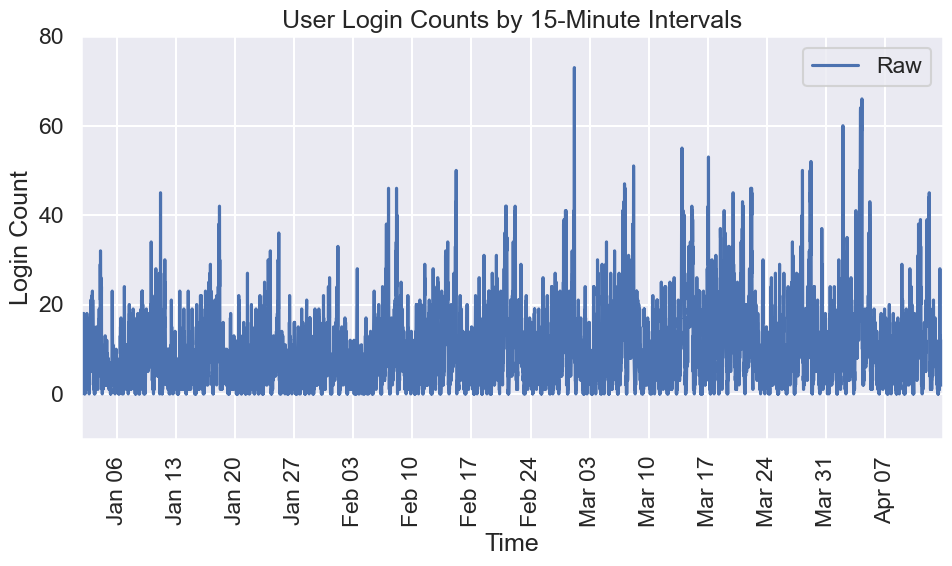

In [4]:
# Plot the time series of login counts
sns.set_theme("talk", style="darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(logins_count["Counts"], label='Raw', color='b')

plt.title('User Login Counts by 15-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Login Count')

plt.legend()
plt.xlim(logins_count.index[0],logins_count.index[-1])
plt.ylim(-10,80)
plt.xticks(rotation=90)
# Format x-tick labels to show the date in 'Weekday, Month Day' format
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())  # Place ticks weekly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format the label
plt.tight_layout()
plt.show()

**The resulting counts seems to lack and trend but has some weekly seasonality. This is particularly difficult to descern here with the raw data. Therefore, I am smoothing the data by taking a rolling mean with th ewindow of one day as below.**

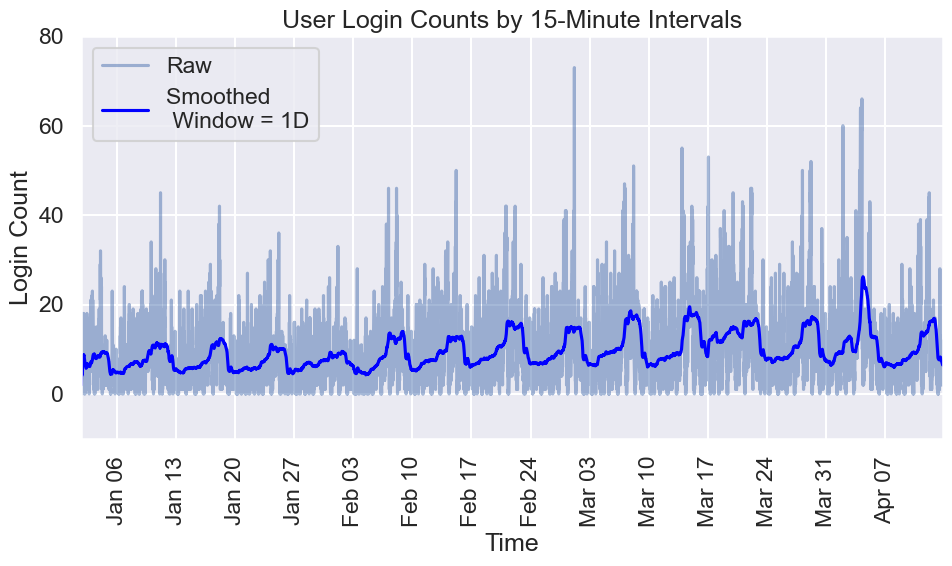

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(logins_count["Counts"], label='Raw', color='b', alpha = 0.5)
plt.plot(logins_count["Counts"].rolling(window="1D").mean(), label='Smoothed \n Window = 1D', color='blue')

plt.title('User Login Counts by 15-Minute Intervals')
plt.xlabel('Time')
plt.ylabel('Login Count')

plt.legend()
plt.xlim(logins_count.index[0],logins_count.index[-1])
plt.ylim(-10,80)
plt.xticks(rotation=90)
# Format x-tick labels to show the date in 'Weekday, Month Day' format
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())  # Place ticks weekly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format the label
plt.tight_layout()
plt.show()

This approach was very usefull in visualizing underlying weekly seasonality. Further, I wanted to visualize which time of the day in average has most logins by creating a new column "time_of_day". After this I used this new column to aggregate the login counts by "time_of_day" to come up with new timeseries `average_demand_by_daytime`

In [6]:
logins_count['time_of_day'] = logins_count.index.time
# Group by 'time_of_day' and calculate the average login count
average_demand_by_daytime = logins_count.groupby('time_of_day')['Counts'].mean()

# Sort by time to ensure proper chronological order
average_demand_by_daytime = average_demand_by_daytime.sort_index()
average_demand_by_daytime

time_of_day
00:00:00    14.107843
00:15:00    15.166667
00:30:00    14.950980
00:45:00    14.529412
01:00:00    15.186275
              ...    
22:45:00    16.049020
23:00:00    15.421569
23:15:00    15.215686
23:30:00    14.274510
23:45:00    14.480392
Name: Counts, Length: 96, dtype: float64

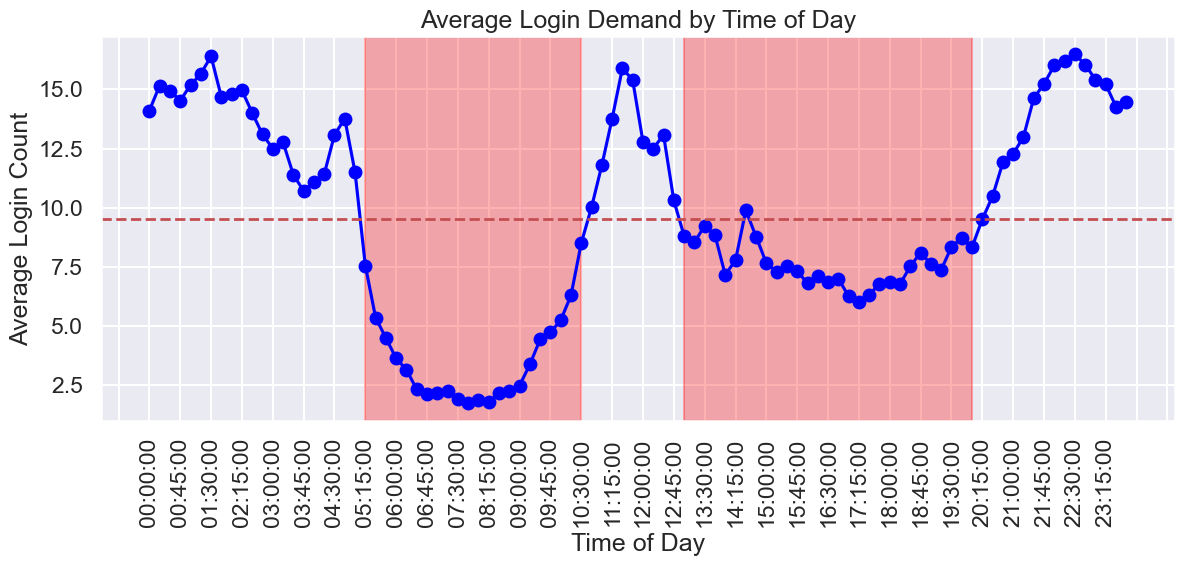

The time of day with the highest average demand is: 22:30:00
The time of day with the least average demand is: 07:45:00


In [7]:
plt.figure(figsize=(12, 6))
plt.plot(average_demand_by_daytime.index.astype("str"), average_demand_by_daytime.values, marker='o', linestyle='-', color='blue')
plt.title('Average Login Demand by Time of Day')
plt.axhline(average_demand_by_daytime.values.mean(), color='r', linestyle='--', linewidth=2, label='mean')
plt.xlabel('Time of Day')
plt.ylabel('Average Login Count')
plt.grid(True)
plt.xticks(rotation=90)
# Highlight the shaded region between 05:15:00 and 10:30:00
plt.axvspan('05:15:00', '10:30:00', color='red', alpha=0.3, label='Time Range 1: 05:15 - 10:30')

# Highlight the shaded region between 12:45:00 and 20:15:00
plt.axvspan('13:00:00', '20:00:00', color='red', alpha=0.3, label='Time Range 2: 12:45 - 20:15')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=36))
plt.show()

# Find the time of day with the highest demand
peak_time = average_demand_by_daytime.idxmax()
lowest_time = average_demand_by_daytime.idxmin()
print(f"The time of day with the highest average demand is: {peak_time}")
print(f"The time of day with the least average demand is: {lowest_time}")

The demand is observed to be lower than average between `05:15:00` - `10:30:00` and `13:00:00` - `20:00:00`, as indicated by the shaded regions in the plot, which correspond to typical working hours. This pattern suggests that during these periods, the clients’ business activity slows down. The dip is followed by a notable peak around noon, which is commonly associated with the lunch break, a time when people tend to step away from work, contributing to reduced activity.

However, as the day progresses, especially in the afternoon, the demand, though still lower than average, shows an increasing trend in client logins compared to the morning hours. This suggests that clients tend to gradually return to work after lunch, logging in at a higher rate despite the overall lower activity during those working hours.

Similarly, I wanted to visualize which day of the week in average has most logins by creating a new column "day_of_week". After this I used this new column to aggregate the login counts by "day_of_week" to come up with new timeseries weekly_pattern

In [8]:
logins_count["day_of_week"] = logins_count.index.dayofweek
weekly_pattern = logins_count.groupby('day_of_week')['Counts'].mean()
weekly_pattern

day_of_week
0     6.213380
1     6.895833
2     7.692708
3     8.794118
4    10.561111
5    13.456250
6    12.615972
Name: Counts, dtype: float64

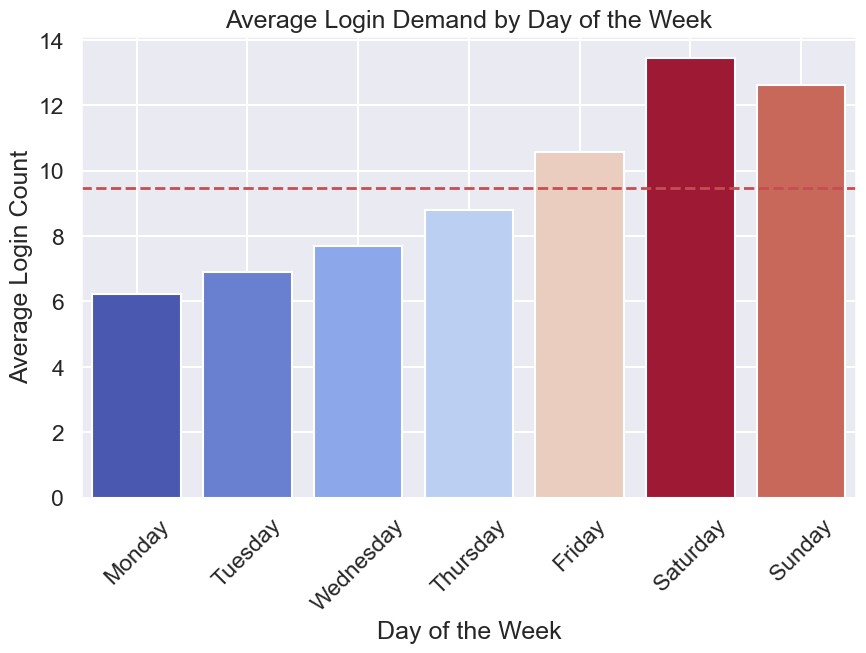

In [9]:
# Create a colormap based on the values in weekly_pattern
norm = plt.Normalize(vmin=weekly_pattern.min(), vmax=weekly_pattern.max())
cmap = plt.cm.coolwarm 
colors = [cmap(norm(val)) for val in weekly_pattern.values]

days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
sns.barplot(x = days, y= weekly_pattern,hue = days,  palette=colors)
plt.title('Average Login Demand by Day of the Week')
plt.axhline(weekly_pattern.values.mean(), color='r', linestyle='--', linewidth=2, label='mean')
plt.xlabel('Day of the Week')
plt.ylabel('Average Login Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Clearly, loging rates increases from Monday through Saturday to reach maximum on Saturday with slight decrease on Sunday.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of **Gotham** and **Metropolis** have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

**1) What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?**

> The key measure of success for this experiment in encouraging driver partners to serve both cities would likely be the number of driver partners who serve both cities, measured by the **percentage increase in driver partners operating in both Gotham and Metropolis after the reimbursement of toll costs**. The reson behind me taking this as a metric are listed as follows.
> * **It directly aligns with the experiment's goal** : The primary goal of reimbursing toll costs is to encourage driver partners to serve both cities. Measuring the change in the number of dual-city drivers directly evaluates whether the incentive works as intended.
> * **It is something that can be measured** : This metric can be calculated using trip data from driver partners, identifying those who take trips in both cities within a specific timeframe. Comparing these numbers before and after the intervention provides a clear measure of the experiment's impact.
> * **It is neutral to other external factors** : Focusing on the number of dual-city drivers rather than total trips helps isolate the effect of toll reimbursement from other factors like demand fluctuations, promotions, or external events.


**2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:**

>**a) how you will implement the experiment**

>**b) what statistical test(s) you will conduct to verify the significance of the
observation**

>**c) how you would interpret the results and provide recommendations to the city
operations team along with any caveats.**

My Experimental design would be described as follows.
> * **Objective**  : To assess whether reimbursing toll costs effectively increases the number of driver partners serving both Gotham and Metropolis.
> * **Experiment Setup** :
>> * **Selection Criterion** : All driver partners operating in either Gotham or Metropolis who has completed at least 15 trips in the past month to sort out the active ones from general population are selected for this experiment. This would save a lot of money for the company as they do not have to implement the program right away to whole population.
>> * **Random selection** : The selected driver partners would then be divided into two groups, a) `Treatment Group`, b) `Control group` randomly to avoid any bias of driver characteristics. Here, instead of comparing the data before and after the implementation to remove any outside factor effects such as holidays, seasons etc. Also, a stratified random selection would be carried out to make the experiment balanced representation of drivers from both cities and with similar historical activity levels in each group.
>> * **Experiment duration** : The experiment will be carried out for `4-6 weeks`, which is long enough to capture any behavioural changes and short enough to maintain experimental control and lower cost.
> * **Implementation** :
>> * **Treatment Group** : Selected drivers are notified via the app that they are selected for the toll reimbursement program and are reimbursed for all tolls incurred for cross-city trips.
>> * **Control Group** : Continue with no toll reimbursement.
>> * **Data Tracking** : Use the app to monitor:
>>> * Driver locations before and after trips.
>>> * Trips crossing the toll bridge.
>>> * Reimbursement payouts for the treatment group.
> * **Statistical Test: Chi-Square Test of Independence** : In our case, the primary metric is categorical (dual-city driver: Yes/No), and we want to compare the proportions between two independent groups (`treatment vs. control`). 
>> * **Null Hypothesis ($𝐻_0$)** : The proportion of dual-city drivers is the same for the treatment and control groups.
>> * **Alternative Hypothesis ($𝐻_A$)** : The proportion of dual-city drivers is different between the treatment and control groups.
> * **Interpretation & Recommendation** :
>> * **Significant Result (p < 0.05)** : We would reject the null hypothesis and conclude that there is a statistically significant difference in the proportion of dual-city drivers between the treatment and control groups.
>>> * **Interpretation** : The toll reimbursement program has successfully encouraged more drivers to serve both cities.
>>> * **Recommendation** : Recommend scaling up the reimbursement program across all drivers to enhance cross-city driver availability and improve customer satisfaction.
>> * **Non-Significant Result (p >= 0.05)** : We fail to reject the null hypothesis, meaning the toll reimbursement did not have a significant effect on encouraging more drivers to serve both cities.
>>> * **Interpretation** : The toll reimbursement program may not be effective in encouraging more dual-city drivers.
>>> * **Recommendation** : Consider revising the incentive structure, exploring alternative incentives, or combining toll reimbursement with other benefits (e.g., performance bonuses or flexible schedules).
> * **Caveats to Consider** :
 
>> * **Behavioral Bias** : Drivers in the treatment group might initially change their behavior due to the novelty of the reimbursement, but long-term effectiveness is uncertain.

>>> * **Recommendation**: A follow-up study after a longer period could help determine if the effect is sustainable over time.
>> * **External Factors** : The experiment may be influenced by external factors such as weather, holidays, or other city-specific events (e.g., concerts, conventions) that drive demand independently of the toll reimbursement.

>>> * **Recommendation** : Ensure that the experiment period accounts for such factors or control for them statistically.

>> * **Unintended Consequences** : The toll reimbursement could cause an influx of drivers who are less efficient in terms of service quality or customer satisfaction, leading to a potential increase in complaints or dissatisfaction.

>>> * **Recommendation**: Continuously monitor customer satisfaction metrics and adjust the program if negative side effects arise.


## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file `ultimate_data_challenge.json`. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

> ### Data description
>> * **city** : city this user signed up in
>> * **phone** : primary device for this user
>> * **signup_date** : date of account registration; in the form ‘YYYYMMDD’
>> * **last_trip_date** : the last time this user completed a trip; in the form ‘YYYYMMDD’
>> * **avg_dist** : the average distance in miles per trip taken in the first 30 days after signup
>> * **avg_rating_by_driver** : the rider’s average rating over all of their trips
>> * **avg_rating_of_driver** : the rider’s average rating of their drivers over all of their trips
>> * **surge_pct** : the percent of trips taken with surge multiplier > 1
>> * **avg_surge** : The average surge multiplier over all of this user’s trips
>> * **trips_in_first_30_days** : the number of trips this user took in the first 30 days after signing up
>> * **ultimate_black_user** : TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
>> * **weekday_pct** : the percent of the user’s trips occurring during a weekday

### Loading the dataset
> * **Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?**

In [10]:
ultimate_data_challenge = pd.read_json("ultimate_data_challenge.json")
ultimate_data_challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [11]:
ultimate_data_challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [12]:
ultimate_data_challenge[ultimate_data_challenge.avg_rating_of_driver.isnull()].describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,8122.000000,0.0,8122.000000,8122.000000,8122.000000,8122.000000,8055.000000
mean,0.593327,NaN,1.078210,8.548067,59.050948,7.506267,4.785984
std,0.606755,NaN,0.310306,26.578461,46.859739,7.758616,0.622122
min,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,NaN,1.000000,0.000000,0.000000,2.410000,5.000000
50%,1.000000,NaN,1.000000,0.000000,100.000000,4.715000,5.000000
75%,1.000000,NaN,1.000000,0.000000,100.000000,10.720000,5.000000
max,5.000000,NaN,5.000000,100.000000,100.000000,160.960000,5.000000


In [13]:
ultimate_data_challenge["signup_date"] = pd.to_datetime(ultimate_data_challenge["signup_date"])
ultimate_data_challenge["last_trip_date"] = pd.to_datetime(ultimate_data_challenge["last_trip_date"])
ultimate_data_challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
ultimate_data_challenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [15]:
ultimate_data_challenge.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,41878.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.300000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.900000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.617338,0.222336,NaN,19.958811,37.081503,5.707357,0.446652


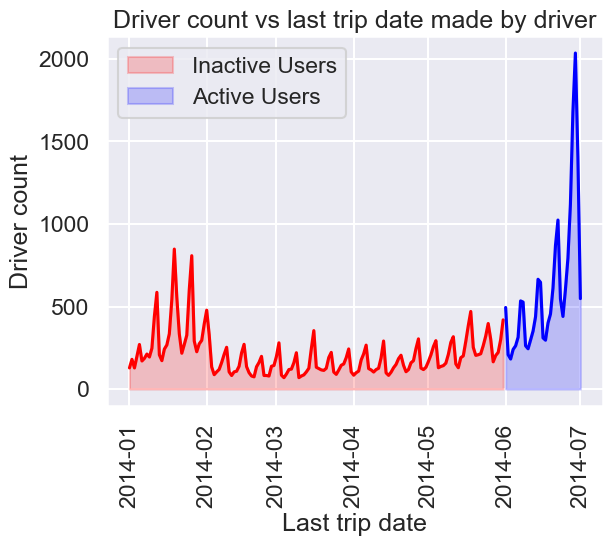

The 36.62 % of users were retained


In [16]:
# Creating last_trip DataFrame
last_trip = pd.DataFrame(ultimate_data_challenge["last_trip_date"].value_counts()).sort_index()

# Color below the plot for the inactive period
plt.fill_between(last_trip.index, 0, last_trip.values.flatten(), where=(last_trip.index < '2014-06-01'), color='red', alpha=0.2, label='Inactive Users')

# Color below the plot for the active period
plt.fill_between(last_trip.index, 0, last_trip.values.flatten(), where=(last_trip.index >= '2014-06-01'), color='blue', alpha=0.2, label='Active Users')

# Adding red line for the 'Inactive'
plt.plot(last_trip.index[last_trip.index < '2014-06-01'],
         last_trip.values.flatten()[last_trip.index < '2014-06-01'],
         color='red')

# Adding blue line for the 'Active'
plt.plot(last_trip.index[last_trip.index >= '2014-06-01'],
         last_trip.values.flatten()[last_trip.index >= '2014-06-01'],
         color='blue')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend and show plot
plt.legend()
plt.title("Driver count vs last trip date made by driver")
plt.xlabel("Last trip date")
plt.ylabel("Driver count")
plt.show()
print(f'The {100 * last_trip[last_trip.index > "2014-06-01"]["count"].sum()/last_trip["count"].sum()} % of users were retained')

For this analysis missing data/ null values which predominanty occur for `avg_rating_of_driver` does not impact. Hence I decided not to process for such data. I wanted to gather similar information among those users which has missing `avg_rating_of_driver` value first to check whether to drop such rows or impute. For this, I reproduced a timeseries fro the subset of the data.

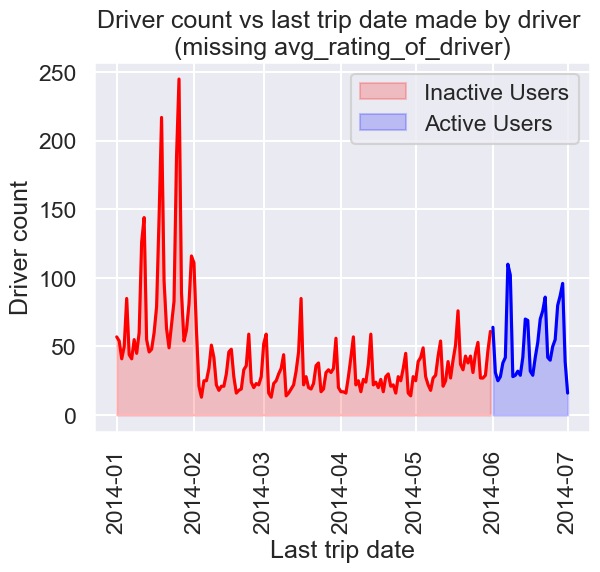

The 19.30558975621768 % of users were reatined


In [17]:
# Creating last_trip DataFrame
last_trip_missing = pd.DataFrame(ultimate_data_challenge[ultimate_data_challenge["avg_rating_of_driver"].isnull()]["last_trip_date"].value_counts()).sort_index()

# Color below the plot for the inactive period
plt.fill_between(last_trip_missing.index, 0, last_trip_missing.values.flatten(), where=(last_trip_missing.index < '2014-06-01'), color='red', alpha=0.2, label='Inactive Users')

# Color below the plot for the active period
plt.fill_between(last_trip_missing.index, 0, last_trip_missing.values.flatten(), where=(last_trip_missing.index >= '2014-06-01'), color='blue', alpha=0.2, label='Active Users')

# Adding red line for the 'Inactive'
plt.plot(last_trip_missing.index[last_trip_missing.index < '2014-06-01'],
         last_trip_missing.values.flatten()[last_trip_missing.index < '2014-06-01'],
         color='red')

# Adding blue line for the 'Active'
plt.plot(last_trip_missing.index[last_trip_missing.index >= '2014-06-01'],
         last_trip_missing.values.flatten()[last_trip_missing.index >= '2014-06-01'],
         color='blue')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Add legend and show plot
plt.legend()
plt.title("Driver count vs last trip date made by driver \n (missing avg_rating_of_driver) ")
plt.xlabel("Last trip date")
plt.ylabel("Driver count")
plt.show()
print(f'The {100 * last_trip_missing[last_trip_missing.index > "2014-06-01"]["count"].sum()/last_trip_missing["count"].sum()} % of users were reatined')

### Data Wrangling and Imputation

The missing values in `avg_rating_of_driver` are significantly different from the original data and could carry some information. Imputing with the median or mean might obscure this information. Therefore, I have decided to impute these missing values with a value of 0, as it may more accurately reflect user dissatisfaction and distinctly set it apart from the rest of the dataset. I have applied the same approach for the `avg_rating_by_driver` column. For `phone` categorical column, I decided to drop it as it has very small number of missing values.

In [18]:
# Impute missing values in 'avg_rating_of_driver' with 0
ultimate_data_challenge['avg_rating_of_driver'] = ultimate_data_challenge['avg_rating_of_driver'].fillna(0)

# Impute missing values in 'avg_rating_by_driver' with 0
ultimate_data_challenge['avg_rating_by_driver'] = ultimate_data_challenge['avg_rating_by_driver'].fillna(0)

# Drop rows with missing values in the 'phone' column
ultimate_data_challenge = ultimate_data_challenge.dropna(subset=['phone'])
ultimate_data_challenge["active"] = ultimate_data_challenge["last_trip_date"]>= '2014-06-01'
ultimate_data_challenge.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [19]:
ultimate_data_challenge.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49604 non-null  object        
 1   trips_in_first_30_days  49604 non-null  int64         
 2   signup_date             49604 non-null  datetime64[ns]
 3   avg_rating_of_driver    49604 non-null  float64       
 4   avg_surge               49604 non-null  float64       
 5   last_trip_date          49604 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               49604 non-null  float64       
 8   ultimate_black_user     49604 non-null  bool          
 9   weekday_pct             49604 non-null  float64       
 10  avg_dist                49604 non-null  float64       
 11  avg_rating_by_driver    49604 non-null  float64       
 12  active                  49604 non-null  bool       

> * **2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.**

The goal is to identify users who are at risk of leaving the company soon (i.e., within the next 6 months), so we can avoid hiring those who may not stick around. This is a churn prediction problem, where our aim should be to predict whether a user will stay or leave.

### Feature, Target selection

Based on the general knowledge `signup_date` should not impact whether a driver will remain active or not at the end of six months. Also, `last_trip_date` won't be available before hiring a new driver. Hence, our feature space should contain '`city`', '`trips_in_first_30_days`', '`avg_rating_of_driver`',   '`avg_surge`', '`phone`', '`surge_pct`', '`ultimate_black_user`', '`weekday_pct`', '`avg_dist`', and '`avg_rating_by_driver`'

In [20]:
ultimate_data_challenge.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active'],
      dtype='object')

In [21]:
X = ultimate_data_challenge[['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 
                             'avg_surge', 'phone', 'surge_pct', 
                             'weekday_pct', 'avg_dist', 'avg_rating_by_driver']]
y = ultimate_data_challenge['active']

In [22]:
X['city'].value_counts()

city
Winterfell        23125
Astapor           16413
King's Landing    10066
Name: count, dtype: int64

In [23]:
X = pd.get_dummies(X, columns=['city', 'phone'], drop_first=True)
X

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,46.2,3.67,5.0,True,False,True
1,0,5.0,1.00,0.0,50.0,8.26,5.0,False,False,False
2,3,4.3,1.00,0.0,100.0,0.77,5.0,False,False,True
3,9,4.6,1.14,20.0,80.0,2.36,4.9,True,False,True
4,14,4.4,1.19,11.8,82.4,3.13,4.9,False,True,False
...,...,...,...,...,...,...,...,...,...,...
49995,0,5.0,1.00,0.0,100.0,5.63,4.2,True,False,True
49996,1,0.0,1.00,0.0,0.0,0.00,4.0,False,False,True
49997,0,5.0,1.00,0.0,100.0,3.86,5.0,False,True,False
49998,2,3.0,1.00,0.0,100.0,4.58,3.5,False,False,True


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=123)

### Gradient Boosting Classifier

In [25]:
# Instantiate the model. I have used GridSearchCV to find best hyperparameters values. 
gb_model = GradientBoostingClassifier(n_estimators=600, learning_rate = 0.1, max_depth = 3, random_state=123)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluate accuracy
recall_score_gb = recall_score(y_test, y_pred_gb)
print(f'Gradient Boosting Recall: {recall_score_gb:.4f}')

Gradient Boosting Recall: 0.6561


### LightGBM Classifier

In [26]:
# Instantiate the model. I have used GridSearchCV to find best hyperparameters values.
lgb_model = lgb.LGBMClassifier(n_estimators=200, max_depth=5, num_leaves = 50,learning_rate = 0.1, random_state=123)

# Train the model
lgb_model.fit(X_train, y_train)

# Make predictions
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate accuracy
recall_score_lgb = recall_score(y_test, y_pred_lgb)
print(f'LightGBM Recall: {recall_score_lgb:.4f}')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 14937, number of negative: 24746
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 912
[LightGBM] [Info] Number of data points in the train set: 39683, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376408 -> initscore=-0.504823
[LightGBM] [Info] Start training from score -0.504823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

### xgboost Classifier

In [27]:
# Instantiate the model. I have used GridSearchCV to find best hyperparameters values. 
xgb_model = XGBClassifier(n_estimators=200, learning_rate = 0.1, max_depth = 5, random_state=123)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate accuracy
recall_score_xgb = recall_score(y_test, y_pred_xgb)
print(f'Gradient Boosting Recall: {recall_score_xgb:.4f}')


Gradient Boosting Recall: 0.6610


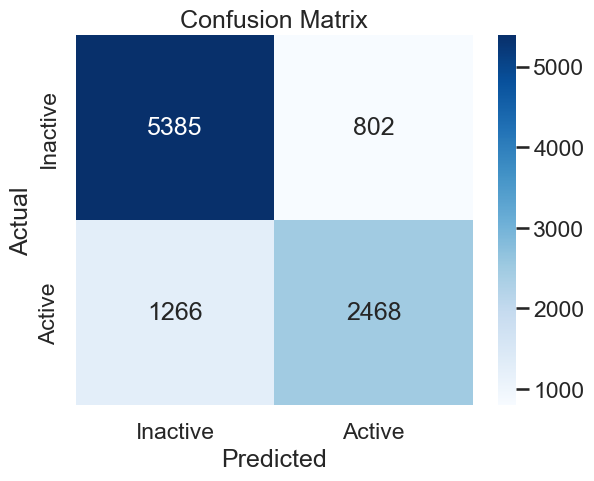

In [28]:
cm = confusion_matrix(y_test, y_pred_xgb)
# Plotting confusion matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Inactive', 'Active'], yticklabels=['Inactive', 'Active'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Extract feature importances from the trained model
feature_importances = xgb_model.feature_importances_
feature_importances

array([0.03529093, 0.02823158, 0.0588412 , 0.06393037, 0.06746572,
       0.01653867, 0.20145659, 0.30112144, 0.03619704, 0.19092645],
      dtype=float32)

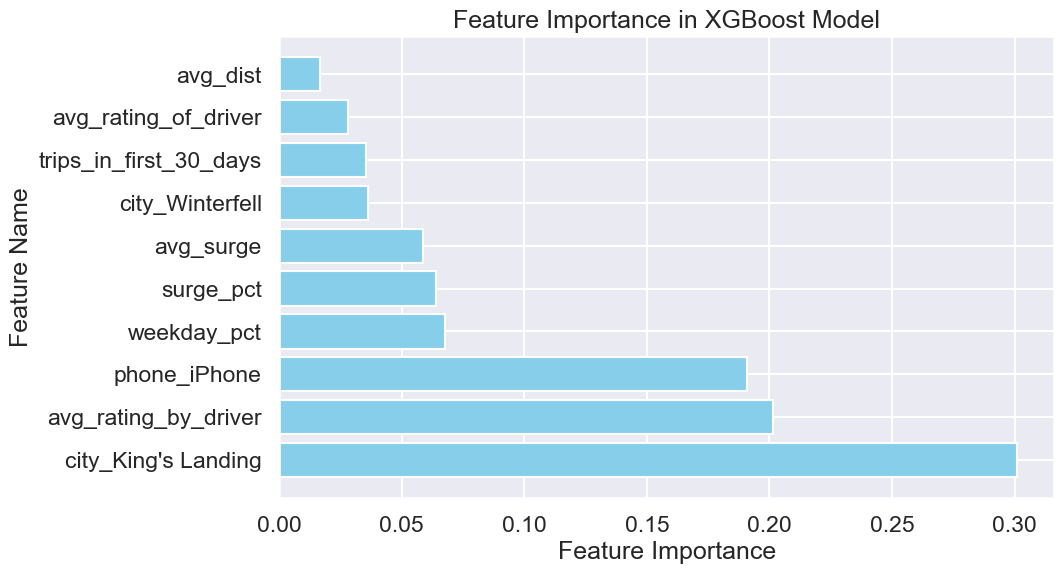

In [30]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame to visualize feature importances
import pandas as pd
feature_names = X.columns  # assuming X_train contains the feature names
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importance in XGBoost Model')
plt.show()


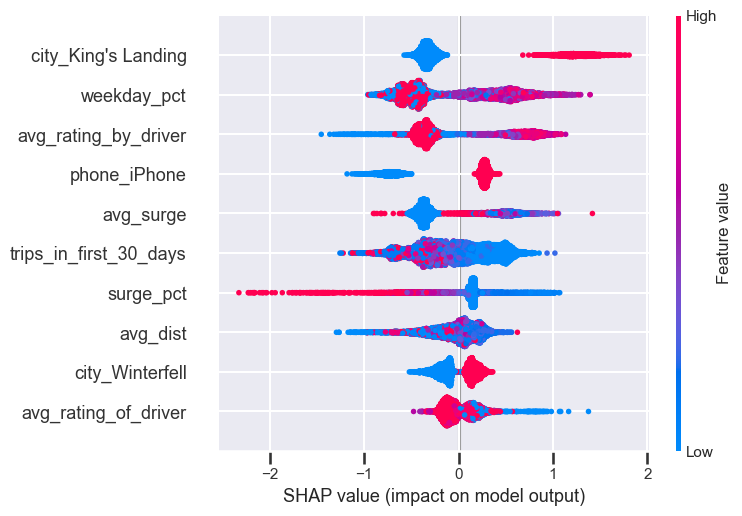

In [31]:
X_test = pd.DataFrame(X_test, columns=X.columns)

# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Get SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the SHAP summary plot for all features
shap.summary_plot(shap_values, X_test)

> * **3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).**

Following conclusion can be drawn from feature importance and their impact on whether the driver will reamin active or not. Which are as follows.
> * Whether driver is coming from King's Landing or not seems to have very high importance, followed by `avg_rating_by_driver` and which phone is used by user.
> * If a person is from King's land, that person seems to remain active after six months. The stretched distribution on the positive side indicates that the positive impact of being from King's Landing is not uniform. Some users from King's Landing might have a stronger positive influence on the retention prediction than others.
> * The red blob being pushed towards the positive side (right) means that having an iPhone tends to increase the likelihood of being retained.

In [33]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9921 entries, 36378 to 32507
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  9921 non-null   int64  
 1   avg_rating_of_driver    9921 non-null   float64
 2   avg_surge               9921 non-null   float64
 3   surge_pct               9921 non-null   float64
 4   weekday_pct             9921 non-null   float64
 5   avg_dist                9921 non-null   float64
 6   avg_rating_by_driver    9921 non-null   float64
 7   city_King's Landing     9921 non-null   bool   
 8   city_Winterfell         9921 non-null   bool   
 9   phone_iPhone            9921 non-null   bool   
dtypes: bool(3), float64(6), int64(1)
memory usage: 649.1 KB
